In [83]:
from IPython.display import display, Math, Latex

In [84]:
import csv
import itertools
import operator
import numpy as np
import scipy as sp
import pandas as pd
import nltk
import sys
from datetime import datetime
from utils import *

import matplotlib.pyplot as plt

%matplotlib inline

### Documentation générale sur les RNN et autres NN pour séquences

• http://colah.github.io/posts/2015-08-Understanding-LSTMs/

• https://cs224d.stanford.edu/lecture_notes/LectureNotes4.pdf

• https://arxiv.org/pdf/1301.3781.pdf

• https://arxiv.org/pdf/1406.1078v3.pdf

• https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html

In [85]:
vocabulary_size = 8000
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

### Managing the database

In [86]:
data = pd.read_table('/Users/Doudou/Desktop/du_côté_de_chez_swann.txt', dtype = str, header = None)
data = data.sum()[0].lower()

sentences = nltk.sent_tokenize(data)
sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]

tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

vocab = word_freq.most_common(vocabulary_size-1)
print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))

index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)

word_to_index = dict([(w, i) for (i, w) in enumerate(index_to_word)])

for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]
    
tokenized_sentences[0]

Found 18681 unique words tokens.
The least frequent word in our vocabulary is 'irons' and appeared 1 times.


['SENTENCE_START',
 'longtemps',
 ',',
 'je',
 'me',
 'suis',
 'couché',
 'de',
 'bonne',
 'heure',
 '.',
 'SENTENCE_END']

### Creating train sets

In [87]:
# Create the training data
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

In [88]:
# nltk.download("book")

### Writing the RNN

$ At \ each \ time \ step \ t:$

$ \ • \ Hidden \ layer: s_t=tanh(U.x_t + W.s_{t-1} + bh) \\ $
$ \ • \ Output \ layer: o_t=softmax(V.s_t + b_o) \ which \ represents \ the  \ probability \ distribution \ over \ the \ vocabulary \ at \ time \ t \\ $
$ \ • \ Cost \ function: \ L = -\sum_{t=1}^{T} y_t \ log(o_t) \\ $


Une solution est proposée ici:

https://github.com/DoctorTeeth/gru/blob/master/rnn.py

In [89]:
class RNN(object):
    
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
    
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize

        self.U = np.random.uniform(-np.sqrt(1./inputLayerSize), np.sqrt(1./inputLayerSize), (hiddenLayerSize, inputLayerSize))
        self.V = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (outputLayerSize, hiddenLayerSize))
        self.W = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (hiddenLayerSize, hiddenLayerSize))
        
        self.bh = np.zeros((1, self.hiddenLayerSize))
        self.bo = np.zeros((1, self.outputLayerSize))
        
        self.parameters = [self.U, self.V, self.W, self.bh, self.bo]
        
    def softmax(self, z):
        return np.exp(z)/(np.sum(np.exp(z)))
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
        
    def forward(self, x):
        
        # - x : une phrase
        
        T = len(x)
        
        # on doit sauvegarder toutes les valeurs de s(t) 
        # s est initialisé avec un vecteur nul en -1
        s = np.zeros((T+1, self.hiddenLayerSize))
        s[-1] = np.zeros(self.hiddenLayerSize)
        
        # o est sauvegardé aussi à chaque étape
        o = np.zeros((T, self.outputLayerSize))
        
        # notons que x(t) est un one-hot-vector, qu'on peut remplacer par l'indice de sa valeur 1 --> x[t] = np.where((x[t]==1))
        for t in np.arange(0, T):
            s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]) + self.bh)
            o[t] = self.softmax(self.V.dot(s[t]) + self.bo)
            
        return [o, s]
            
    def predict(self, x):
        
        # - x : une phrase
        
        o, s = self.forward(x)
        return np.argmax(o, axis = 1)
    
    def costFunction(self, x, y):
        
        # - x : les phrases sans le dernier mot
        # - y : les phrases sans le premier mot

        L = 0
        N = np.sum((len(y_i) for y_i in y))
        
        for i in np.arange(len(x)): # pour chaque phrase
            o, s = self.forward(x[i])
            p = y[i]
            L += -np.sum(np.log(o[np.arange(len(p)),p]))
                
        return L/N
    
    def computeGradient(self, x, y):
    
    # - x : une phrase sans le dernier mot
    # - y : une phrase sans le premier mot
        
        o, s = self.forward(x)
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        
        dLdbh = np.zeros(self.bh.shape)
        dLdbo = np.zeros(self.bo.shape)
        
        mem = np.zeros(self.hiddenLayerSize)
        
        save_grad_coef = []
        sgc = 1

        for t in np.arange(len(x))[::-1]:
            
            x_t = np.array((np.arange(self.inputLayerSize)==x[t]), dtype = float)
            y_t = np.array((np.arange(self.inputLayerSize)==y[t]), dtype = float)
            
            dLdV += np.outer((o[t]-y_t),s[t].T)
            dLdbo += (o[t]-y_t)

            z_t = (self.V.T.dot(o[t]-y_t) + mem)*(1-s[t]**2)
            
            dLdW += np.outer(z_t, s[t-1])
            dLdU += np.outer(z_t, x_t)
            dLdbh += z_t
            
            sgc = sgc*(self.W*np.diag(1-s[t-1]**2))
            save_grad_coef.append(sgc)
            
            mem = self.W.T.dot(z_t)
                
        return [dLdU, dLdV, dLdW, dLdbh, dLdbo], save_grad_coef  
    
    def getParams(self):
        # transform the Ws into vectors
        params = np.concatenate((self.U.ravel(), self.V.ravel(), self.W.ravel(), self.bh.ravel(), self.bo.ravel()))
        return params
    
    def setParams(self, params):
        # enables to replace the Ws by inputing vector of parameters
        # transform parameter vectors into matrices
        
        U_start = 0
        U_end = self.hiddenLayerSize*self.inputLayerSize
        self.U = np.reshape(params[U_start:U_end], (self.hiddenLayerSize, self.inputLayerSize))

        V_end = U_end + self.hiddenLayerSize*self.outputLayerSize
        self.V = np.reshape(params[U_end:V_end], (self.outputLayerSize, self.hiddenLayerSize))
        
        W_end = V_end + self.hiddenLayerSize*self.hiddenLayerSize
        self.W = np.reshape(params[V_end:W_end], (self.hiddenLayerSize, self.hiddenLayerSize))        
        
        bh_end = W_end + self.hiddenLayerSize
        self.bh = np.reshape(params[W_end: bh_end], (1, self.hiddenLayerSize))
        
        bo_end = bh_end + self.outputLayerSize
        self.bo = np.reshape(params[bh_end: bo_end], (1, self.outputLayerSize))

        

In [90]:
def computeNumericalGradient(N, x, y):
    paramsInitial = N.getParams()
    numgrad = np.zeros(paramsInitial.shape)
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4
    
    for p in range(len(paramsInitial)):
        perturb[p] = e
        N.setParams(paramsInitial + perturb)
        loss2 = N.costFunction(x, y)
        
        N.setParams(paramsInitial - perturb)
        loss1 = N.costFunction(x, y)
        
        numgrad[p] = (loss2-loss1)/(2*e)
                
        perturb[p] = 0
    
        N.setParams(paramsInitial)
    
    return numgrad

#### Tester le calcul analytique du gradient

In [91]:
%%time

model = RNN(inputLayerSize=10, hiddenLayerSize = 100, outputLayerSize=10)
x = [[0,1,2,3]]
y = [[1,2,3,4]]

dLdU, dLdV, dLdW, dLdbh, dLdbo = model.computeGradient(x[0], y[0])[0]

anagrad = np.concatenate((dLdU.ravel(), dLdV.ravel(), dLdW.ravel(), dLdbh.ravel(), dLdbo.ravel()))
numgrad = computeNumericalGradient(model, x, y)

CPU times: user 31.8 s, sys: 711 ms, total: 32.5 s
Wall time: 18 s


In [92]:
c = (anagrad[0]/numgrad[0])
np.linalg.norm(numgrad*c-anagrad)/np.linalg.norm(numgrad*c+anagrad)


1.1354388165153913e-09

#### Tester la fonction de coût

In [93]:
print('Cross entropy: ' + str(model.costFunction(x, y)))
print('Coût aléatoire théorique: ' + str(np.log(10)))

Cross entropy: 2.32660962203
Coût aléatoire théorique: 2.30258509299


### Training

In [94]:
class train_rnn(object):
    
    def __init__(self, RNN):
        self.RNN = RNN
        
    def gradientDescentStep(self, x, y, learningRate):
        dLdU, dLdV, dLdW, dLdbh, dLdbo = self.RNN.computeGradient(x, y)[0]
        
        self.RNN.U -= learningRate*dLdU
        self.RNN.V -= learningRate*dLdV
        self.RNN.W -= learningRate*dLdW
        self.RNN.bh -= 0*dLdbh
        self.RNN.bo -= 0*dLdbo
        
    
    def iterateGDSteps(self, X_train, y_train, 
                       learningRate = 0.005, 
                       nepoch = 10, 
                       evaluateLossEvery =10):
        losses = []
        numExamples = 0
        
        for e in np.arange(nepoch):
            print(e)
            if (e%(evaluateLossEvery-1)==0):
                loss = self.RNN.costFunction(X_train, y_train)
                losses.append({"numExamples": numExamples, "loss": loss})
                if(len(losses)>1 and losses[-1]['loss']>losses[-2]['loss']):
                    learningRate *= 0.5
                
            for i in np.random.randint(low = 0, high = len(y_train), size = 10):
                self.gradientDescentStep(X_train[i], y_train[i], learningRate)
                numExamples +=1
                
        return losses
            

In [95]:
model_rnn = RNN(inputLayerSize=vocabulary_size, hiddenLayerSize= 100, outputLayerSize=vocabulary_size)
T_rnn = train_rnn(model_rnn)


In [96]:
randomlyFound = []

for i, y in enumerate(y_train[:20]):
    randomlyFound.append((np.sum(T_rnn.RNN.predict(X_train[i])==np.array(y_train[i])), len(y_train[i])))

print(pd.DataFrame(randomlyFound).sum())

0      0
1    869
dtype: int64


In [97]:
print(T_rnn.RNN.costFunction(X_train[:20], y_train[:20]))

8.98729752372


In [98]:
T_rnn.iterateGDSteps(X_train[:100], y_train[:100])

0
1
2
3
4
5
6
7
8
9


[{'loss': 8.9874048177973993, 'numExamples': 0},
 {'loss': 8.9726087796771914, 'numExamples': 90}]

%%time

r = np.random.permutation(20)

for k in range(20):
    i = np.random.randint(low = 0, high = 20)
    T_rnn.gradientDescentStep(X_train[i], y_train[i], .05)

In [99]:
learnedLinksRNN = []

for i, y in enumerate(y_train[:100]):
    learnedLinksRNN.append((np.sum(T_rnn.RNN.predict(X_train[i])==np.array(y_train[i])),len(y_train[i])))

In [100]:
print('RNN learning performance')
print(pd.DataFrame(learnedLinksRNN).sum())

RNN learning performance
0     462
1    7262
dtype: int64


In [101]:
X_test = X_train[-100:]
y_test = y_train[-100:]

predictedLinksRNN = []

for i, y in enumerate(y_test):
    predictedLinksRNN.append((np.sum(T_rnn.RNN.predict(X_test[i])==np.array(y_test[i])),len(y_test[i])))
    

In [102]:
print('RNN prediction performance')
print(pd.DataFrame(predictedLinksRNN).sum())

RNN prediction performance
0     275
1    4938
dtype: int64


In [103]:
print(T_rnn.RNN.costFunction(X_train[:100], y_train[:100]))

8.96818160945


#### Illustrating the gradient vanishing

Explication du phénomène : 

http://proceedings.mlr.press/v28/pascanu13.pdf

In [104]:
model = RNN(inputLayerSize=vocabulary_size, hiddenLayerSize= 100, outputLayerSize=vocabulary_size)
T = train_rnn(model)


In [105]:
A = T.RNN.computeGradient(X_train[1], y_train[1])

[0.56999999999999995, 0.040000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


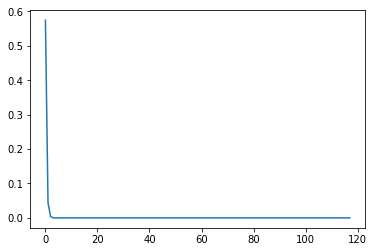

In [106]:
print([np.round(np.linalg.norm(a), 2) for a in A[1]])

plt.plot(np.array([np.linalg.norm(a) for a in A[1]]))

Résolution du problème de gradient évanescent :

• Utilisation de fonction d'activation ReLU, dont la dérivée est 0 ou 1, et ne subit pas d'atténuation continue dans le temps (peut persister le problème de la disparition d'une couche à l'autre de toute l'information mémorisée)

• Introduction de modèles dont les couches cachées contiennent des portes dérobées permettant à l'information de passer directement du temps $ t-1 $ au temps $ t $ sans subir le produit par $ \frac{\partial s_t}{\partial s_{t-1}} $


### Generation automatique de texte

In [107]:
def generate_text(model, 
                  index_to_word, 
                  word_to_index, 
                  sentence_start_token, 
                  sentence_end_token, 
                  unknown_token, 
                  max_length):
    # rappel
    # index_to_word[index] = word
    # word_to_index[word] = index
    
    text = [word_to_index[sentence_start_token]]
    
    while (not text[-1]==sentence_end_token) and (not len(text)>max_length):
        dist_new_word = model.forward(text)[0][-1]
        sampling = np.random.multinomial(1, dist_new_word)
        text.append(np.argmax(sampling))
        
    return [index_to_word[w] for w in text]


In [108]:
generate_text(T_rnn.RNN, 
              index_to_word, 
              word_to_index, 
              sentence_start_token, 
              sentence_end_token, 
              unknown_token, 100)

['SENTENCE_START',
 'mollement',
 'relative',
 'denses',
 'plaine',
 '«est-ce',
 "s'occuper",
 'analogue',
 "d'eau",
 'pourtant',
 'patience',
 'éloignions',
 'buvait',
 'amants',
 'livrer',
 'combien',
 'pendules',
 'attendrissement',
 'témoignait',
 'invité',
 'nom',
 'noires',
 "s'arranger.»",
 'vague',
 'sainte',
 'découragé',
 'malice',
 'aides',
 "l'intention",
 'facteurs',
 'crée',
 'lointaines',
 'machine',
 'montrent',
 'voudriez',
 'limpide',
 'sache',
 'rendre',
 'allaient',
 'fraîcheur',
 'rapide',
 'file',
 'pierres',
 'réciproque',
 'auge',
 'cessât',
 '»ou',
 'pise',
 'drap',
 'fâcheux',
 "d'acier",
 "l'escalier",
 "l'ancienne",
 'demandait',
 'soulagement',
 'priait',
 'dorées',
 'pour',
 'contingences',
 'attitudes',
 'réputation',
 'francs',
 'glacé',
 'isolé',
 'troupier',
 'charmant',
 'proposition',
 'cène',
 'allé',
 'coquelin',
 'gris',
 "s'éleva",
 'brillantes',
 'sentiment',
 'aimât',
 'habituer',
 'caprice',
 "n'y",
 'grandes',
 '—«oui',
 'attitudes',
 'attrib

### RNN bidirectionnel

• http://www.di.ufpe.br/%7Efnj/RNA/bibliografia/BRNN.pdf (papier original BRNN)

• https://arxiv.org/pdf/1504.01575.pdf (utilisation de BRNN pour l'interpolation dans des séries temporelles pour compléter les valeurs manquantes)

$ At \ each \ time \ step \ t:$

$ \ • \ Hidden \ up \ layer: s_t^{up}=tanh(U^{up}.x_t + W^{up}.s^{up}_{t-1} + b_h^{up}) \\ $

$ \ • \ Hidden \ down \ layer: s_t^{down}=tanh(U^{down}.x_t + W^{down}.s^{down}_{t+1} + b_h^{down}) \\ $

$ \ • \ Output \ layer: o_t=softmax(V^{up}.s_t^{up} + V^{down}.s_t^{down} + b_o) \ which \ represents \ the  \ probability \ distribution \ over \ the \ vocabulary \ at \ time \ t \\ $

$ \ • \ Cost \ function: \ L = -\sum_{t=1}^{T} y_t \ log(o_t) \\ $


In [109]:
class BRNN(object):
    
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
    
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize

        self.U_up = np.random.uniform(-np.sqrt(1./inputLayerSize), np.sqrt(1./inputLayerSize), (hiddenLayerSize, inputLayerSize))
        self.V_up = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (outputLayerSize, hiddenLayerSize))
        self.W_up = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (hiddenLayerSize, hiddenLayerSize))
        
        self.U_down = np.random.uniform(-np.sqrt(1./inputLayerSize), np.sqrt(1./inputLayerSize), (hiddenLayerSize, inputLayerSize))
        self.V_down = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (outputLayerSize, hiddenLayerSize))
        self.W_down = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (hiddenLayerSize, hiddenLayerSize))
        
        self.bh_up = np.zeros((1, self.hiddenLayerSize))
        self.bh_down = np.zeros((1, self.hiddenLayerSize))
        self.bo = np.zeros((1, self.outputLayerSize))
        
        self.parameters = [self.U_up, self.V_up, self.W_up, self.bh_up,
                           self.U_down, self.V_down, self.W_down, self.bh_down, 
                           self.bo]
        
    def softmax(self, z):
        return np.exp(z)/(np.sum(np.exp(z)))
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
        
    def forward(self, x):
        
        T = len(x)
        
        # on doit sauvegarder toutes les valeurs de s(t) 
        # s est initialisé avec un vecteur nul en -1
        s_up = np.zeros((T+1, self.hiddenLayerSize))
        s_up[-1] = np.zeros(self.hiddenLayerSize)
        
        s_down =np.zeros((T+1, self.hiddenLayerSize))
        # s_down[T] = np.zeros(self.hiddenLayerSize)
        
        # o est sauvegardé aussi à chaque étape
        o = np.zeros((T, self.outputLayerSize))
        
        # notons que x(t) est un one-hot-vector, qu'on peut remplacer par l'indice de sa valeur 1 --> x[t] = np.where((x[t]==1))
        for t in np.arange(0, T):
            s_up[t] = np.tanh(self.U_up[:,x[t]] + self.W_up.dot(s_up[t-1]) + self.bh_up)
            s_down[T-t-1] = np.tanh(self.U_down[:,x[T-t-1]] + self.W_down.dot(s_down[T-t]) + self.bh_down)
        
        for t in np.arange(0, T):
            o[t] = self.softmax(self.V_down.dot(s_down[t]) + 
                                self.V_up.dot(s_up[t]) + 
                                self.bo)
            
        return [o, s_up, s_down]
        
    def predict(self, x):
    # Inputs:
        # x : une phrase
    # Outputs:
        # estimated word based on maximum computed probability
        
        o, s_up, s_down = self.forward(x)
        return np.argmax(o, axis = 1)
    
    def costFunction(self, x, y):
        
        # - x : les phrases sans le dernier mot
        # - y : les phrases sans le premier mot

        L = 0
        N = np.sum((len(y_i) for y_i in y))
        
        for i in np.arange(len(x)): # pour chaque phrase
            o, s_up, s_down = self.forward(x[i])
            p = y[i]
            L += -np.sum(np.log(o[np.arange(len(p)),p]))
                
        return L/N
    
    def computeGradient(self, x, y):
    
    # - x : une phrase sans le dernier mot
    # - y : une phrase sans le premier mot
    
        o, s_up, s_down = self.forward(x)
        
        dLdU_up = np.zeros(self.U_up.shape)
        dLdV_up = np.zeros(self.V_up.shape)
        dLdW_up = np.zeros(self.W_up.shape)
        
        dLdU_down = np.zeros(self.U_down.shape)
        dLdV_down = np.zeros(self.V_down.shape)
        dLdW_down = np.zeros(self.W_down.shape)
        
        dLdbh_up = np.zeros(self.bh_up.shape)
        dLdbh_down = np.zeros(self.bh_down.shape)
        dLdbo = np.zeros(self.bo.shape)
 
        dsds_up = np.zeros(self.hiddenLayerSize)
        dsds_down = np.zeros(self.hiddenLayerSize)
        
        for t in np.arange(len(x))[::-1]:
            
            x_t = np.identity(self.inputLayerSize)[:,x[t]]
            y_t = np.identity(self.outputLayerSize)[:,y[t]]
            
            ds_upt = (self.V_up.T.dot(o[t]-y_t) + dsds_up)*(1-s_up[t]**2)
            
            ds_downt = (self.V_down.T.dot(o[t]-y_t) + dsds_down)*(1-s_down[t]**2)
            
            # updates
            
            dLdV_up += np.outer((o[t]-y_t),s_up[t])
            dLdU_up += np.outer(ds_upt, x_t)
            dLdW_up += np.outer(ds_upt, s_up[t-1])
            dLdbh_up += ds_upt
            dsds_up = self.W_up.T.dot(ds_upt)
            
            
            dLdV_down += np.outer((o[t]-y_t),s_down[t])
            dLdU_down += np.outer(ds_downt, x_t)
            dLdW_down += np.outer(ds_downt, s_down[t+1])
            dLdbh_down += ds_downt
            dsds_down = self.W_down.T.dot(ds_downt)
            
            dLdbo += (o[t]-y_t)
            
        return dLdU_up, dLdV_up, dLdW_up, dLdbh_up,  dLdU_down, dLdV_down, dLdW_down, dLdbh_down, dLdbo
        
    
    def getParams(self):
        # transform the Ws into vectors
        params = np.concatenate((self.U_up.ravel(), self.V_up.ravel(), self.W_up.ravel(), self.bh_up.ravel(), 
                                 self.U_down.ravel(), self.V_down.ravel(), self.W_up.ravel(), self.bh_down.ravel(), 
                                 self.bo.ravel()))
        return params
    
    def setParams(self, params):
        # enables to replace the Ws by inputing vector of parameters
        # transform parameter vectors into matrices
 
        _start = 0
        _end = np.product(self.U_up.shape)
        self.U_up = np.reshape(params[_start:_end], self.U_up.shape)

        _start = _end
        _end = _end + np.product(self.V_up.shape)
        self.V_up = np.reshape(params[_start:_end], self.V_up.shape)
        
        _start = _end
        _end = _end + np.product(self.W_up.shape)
        self.W_up = np.reshape(params[_start:_end], self.W_up.shape)
        
        _start = _end
        _end = _end + np.product(self.bh_up.shape)
        self.bh_up = np.reshape(params[_start:_end], self.bh_up.shape)
        
        _start = 0
        _end = np.product(self.U_down.shape)
        self.U_down = np.reshape(params[_start:_end], self.U_down.shape)

        _start = _end
        _end = _end + np.product(self.V_down.shape)
        self.V_down = np.reshape(params[_start:_end], self.V_down.shape)
        
        _start = _end
        _end = _end + np.product(self.W_down.shape)
        self.W_down = np.reshape(params[_start:_end], self.W_down.shape)
        
        _start = _end
        _end = _end + np.product(self.bh_down.shape)
        self.bh_down = np.reshape(params[_start:_end], self.bh_down.shape)
        
        _start = _end
        _end = _end + np.product(self.bo.shape)
        self.bo = np.reshape(params[_start:_end], self.bo.shape)
        
        

#### Tester le calcul analytique du gradient

model_rnn = RNN(inputLayerSize=10, hiddenLayerSize = 10, outputLayerSize=10)
model_brnn = BRNN(inputLayerSize=10, hiddenLayerSize = 10, outputLayerSize=10)

x = [[0,1,2,3]]
y = [[1,2,3,4]]

x_inv = [y[0][::-1]]
y_inv = [x[0][::-1]]

model_brnn.U_up = model_rnn.U
model_brnn.V_up = model_rnn.V
model_brnn.W_up = model_rnn.W
model_brnn.bh_up = model_rnn.bh

model_brnn.U_down = np.zeros(model_brnn.U_down.shape)
model_brnn.V_down = np.zeros(model_brnn.V_down.shape)
model_brnn.W_down = np.zeros(model_brnn.W_down.shape)
model_brnn.bh_down = np.zeros(model_brnn.bh_down.shape)



model_brnn.U_down = model_rnn.U
model_brnn.V_down = model_rnn.V
model_brnn.W_down = model_rnn.W
model_brnn.bh_down = model_rnn.bh

model_brnn.U_up = np.zeros(model_brnn.U_up.shape)
model_brnn.V_up = np.zeros(model_brnn.V_up.shape)
model_brnn.W_up = np.zeros(model_brnn.W_up.shape)
model_brnn.bh_up = np.zeros(model_brnn.bh_up.shape)


A = model_brnn.computeGradient(x[0], y[0])
B = model_rnn.computeGradient(x[0], y[0])[0]


%%time

model = BRNN(inputLayerSize=10, hiddenLayerSize = 10, outputLayerSize=10)

x = [[0,1,2,3]]
y = [[1,2,3,4]]

dLdU_up, dLdV_up, dLdW_up, dLdbh_up, dLdU_down, dLdV_down, dLdW_down, dLdbh_down, dLdbo = model.computeGradient(x[0], y[0])

anagrad = np.concatenate((dLdU_up.ravel(), dLdV_up.ravel(), dLdW_up.ravel(), dLdbh_up.ravel(), 
                          dLdU_down.ravel(), dLdV_down.ravel(), dLdW_down.ravel(), dLdbh_down.ravel(), 
                          dLdbo.ravel()))

numgrad = computeNumericalGradient(model, x, y)

model_num = BRNN(inputLayerSize=10, hiddenLayerSize = 10, outputLayerSize=10)
model_num.setParams(numgrad)


c = (dLdV_up.ravel()[0]/model_num.V_up.ravel()[0])
np.linalg.norm(model_num.V_up.ravel()*c-dLdV_up.ravel())/np.linalg.norm(model_num.V_up.ravel()*c+dLdV_up.ravel())


c = (dLdbo.ravel()[0]/model_num.bo.ravel()[0])
np.linalg.norm(model_num.bo.ravel()*c-dLdbo.ravel())/np.linalg.norm(model_num.bo.ravel()*c+dLdbo.ravel())


c = (anagrad[0]/numgrad[0])
np.linalg.norm(numgrad*c-anagrad)/np.linalg.norm(numgrad*c+anagrad)


#### Tester la fonction de coût

In [119]:
print('Cross entropy: ' + str(model.costFunction(x, y)))
print('Coût aléatoire théorique: ' + str(np.log(10)))

Cross entropy: 2.13978549096
Coût aléatoire théorique: 2.30258509299


In [120]:
class train_brnn(object):
    
    def __init__(self, BRNN):
        self.BRNN = BRNN
        
    def gradientDescentStep(self, x, y, learningRate):
        dLdU_up, dLdV_up, dLdW_up, dLdbh_up, dLdU_down, dLdV_down, dLdW_down, dLdbh_down, dLdbo = self.BRNN.computeGradient(x, y)

        self.BRNN.U_up -= learningRate*dLdU_up
        self.BRNN.V_up -= learningRate*dLdV_up
        self.BRNN.W_up -= learningRate*dLdW_up
        self.BRNN.bh_up -= learningRate*dLdbh_up
        self.BRNN.U_down -= learningRate*dLdU_down
        self.BRNN.V_down -= learningRate*dLdV_down
        self.BRNN.W_down -= learningRate*dLdW_down
        self.BRNN.bh_down -= learningRate*dLdbh_down
        self.BRNN.bo -= learningRate*dLdbo
        
    
    def iterateGDSteps(self, X_train, y_train, 
                       learningRate = 0.005, 
                       nepoch = 10, 
                       evaluateLossEvery =10):
        losses = []
        numExamples = 0
        
        for e in np.arange(nepoch):
            print(e)
            if (e%(evaluateLossEvery-1)==0):
                loss = self.BRNN.costFunction(X_train, y_train)
                losses.append({"numExamples": numExamples, "loss": loss})
                if(len(losses)>1 and losses[-1]['loss']>losses[-2]['loss']):
                    learningRate *= 0.5
                
            for i in np.random.randint(low = 0, high = len(y_train), size = 10):
                self.gradientDescentStep(X_train[i], y_train[i], learningRate)
                numExamples +=1
                
        return losses
            

In [121]:
model_brnn = BRNN(inputLayerSize=vocabulary_size, hiddenLayerSize= 100, outputLayerSize=vocabulary_size)
T_brnn = train_brnn(model_brnn)


In [122]:
randomlyFound = []

for i, y in enumerate(y_train[:20]):
    randomlyFound.append((np.sum(T_brnn.BRNN.predict(X_train[i])==np.array(y_train[i])), len(y_train[i])))

print(pd.DataFrame(randomlyFound).sum())

0      0
1    869
dtype: int64


In [123]:
print(T_brnn.BRNN.costFunction(X_train[:20], y_train[:20]))

8.98745278239


In [124]:
T_brnn.iterateGDSteps(X_train[:100], y_train[:100])

0
1
2
3
4
5
6
7
8
9


[{'loss': 8.9875026677208218, 'numExamples': 0},
 {'loss': 6.6857495672334872, 'numExamples': 90}]

%%time

r = np.random.permutation(20)

for k in range(20):
    i = np.random.randint(low = 0, high = 20)
    T_rnn.gradientDescentStep(X_train[i], y_train[i], .05)

In [125]:
learnedLinksBRNN = []

for i, y in enumerate(y_train[:100]):
    learnedLinksBRNN.append((np.sum(T_brnn.BRNN.predict(X_train[i])==np.array(y_train[i])),len(y_train[i])))


In [126]:
print('RNN learning performance')
print(pd.DataFrame(learnedLinksRNN).sum())

print('BRNN learning performance')
print(pd.DataFrame(learnedLinksBRNN).sum())


RNN learning performance
0     462
1    7262
dtype: int64
BRNN learning performance
0     447
1    7262
dtype: int64


In [127]:
X_test = X_train[-100:]
y_test = y_train[-100:]

predictedLinksBRNN = []

for i, y in enumerate(y_test):
    predictedLinksBRNN.append((np.sum(T_brnn.BRNN.predict(X_test[i])==np.array(y_test[i])),len(y_test[i])))
    

In [128]:
print('RNN prediction performance')
print(pd.DataFrame(predictedLinksRNN).sum())

print('BRNN prediction performance')
print(pd.DataFrame(predictedLinksBRNN).sum())

RNN prediction performance
0     275
1    4938
dtype: int64
BRNN prediction performance
0     321
1    4938
dtype: int64


In [129]:
print(T_rnn.RNN.costFunction(X_train[:100], y_train[:100]))

8.96818160945


### GRU

At each time step t:

• New memory layer: $ m_t=tanh(U^m.x_t + r_t \times W^m.s_{t-1} + b^m): \\ $

• Reset gate: $ r_t=\sigma (U^r.x_t + W^r.s_{t-1} + b^r) \\ $

• Interpolation gate: $ z_t=\sigma (U^z.x_t + W^z.s_{t-1} + b^z) \\ $

• Hidden layer: $ s_t = (1-z_t) \times m_t + z_t \times s_{t-1} \\ $

• Output layer: $ o_t=softmax(V.s_t + b_o) \\ $

• Cost function: $ L = -\sum_{t=1}^{T} y_t \ log(o_t) \\ $


Cette architecture permet d'améliorer la persistance de la mémoire dans le réseau en proposant des passages directs contrôlés par des portes. On compte trois types de porte:

- Les "new memory layers candidate" $ m_t $ permettent de compléter l'information au temps $ t $ contenue dans $ s_t $ en combinant l'information contenue dans $ x_t $ avec de l'information passée contenue dans $ s_{t-1} $

- Les "reset gates" $ r_t $ contrôlent la persistance de l'information passée $ s_{t-1} $ utilisée pour la construction de la mémoire $ m_t $

- Les "update gates" $ z_t $ contrôlent la balance entre "new memory" et "previous hidden states" pour la construction du nouvelle état caché

- Les "hidden states" $ s_t $ sont générés par arbitrage entre "new memory" et "past hidden state"

- L'output $ o_t $ represents the  estimated probability distribution over the vocabulary at time, sachant l'information passée contenue dans l'état caché $ s_t $

Une solution est proposée ici: 

https://github.com/DoctorTeeth/gru/blob/master/gru.py

In [130]:
class GRU(object):
    
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
    
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        
        self.Uz = np.random.uniform(-np.sqrt(1./inputLayerSize), np.sqrt(1./inputLayerSize), (hiddenLayerSize, inputLayerSize))
        self.Wz = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (hiddenLayerSize, hiddenLayerSize))
        
        self.Ur = np.random.uniform(-np.sqrt(1./inputLayerSize), np.sqrt(1./inputLayerSize), (hiddenLayerSize, inputLayerSize))
        self.Wr = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (hiddenLayerSize, hiddenLayerSize))
        
        self.Um = np.random.uniform(-np.sqrt(1./inputLayerSize), np.sqrt(1./inputLayerSize), (hiddenLayerSize, inputLayerSize))
        self.Wm = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (hiddenLayerSize, hiddenLayerSize))
        
        self.bm = np.zeros((self.hiddenLayerSize))
        self.br = np.zeros((self.hiddenLayerSize))
        self.bz = np.zeros((self.hiddenLayerSize))
        
        self.V = np.random.uniform(-np.sqrt(1./hiddenLayerSize), np.sqrt(1./hiddenLayerSize), (outputLayerSize, hiddenLayerSize))
        self.bo = np.zeros((self.outputLayerSize))
        
        self.parameters = [self.V, self.bo, 
                           self.Um, self.Wm, self.bm, 
                           self.Ur, self.Wr, self.br, 
                           self.Uz, self.Wz, self.bz]
        
        
    def softmax(self, z):
        return np.exp(z)/(np.sum(np.exp(z)))
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self, z):
        return np.exp(-z)/(1+np.exp(-z))**2
        
    def forward(self, x):
        
        T = len(x)
        
        s = np.zeros((T+1, self.hiddenLayerSize)) # hidden states
        # z, s, r, m, o = {}, {}, {}, {}, {}
        s[-1] = np.zeros(self.hiddenLayerSize) 
        
        m = np.zeros((T, self.hiddenLayerSize)) # candidates
        r = np.zeros((T, self.hiddenLayerSize)) # gates to modulate how much from previous hidden state goes to new candidate
        z = np.zeros((T, self.hiddenLayerSize)) # gates to modulate the interpolation between candidate and previous hidden state
        
        o = np.zeros((T, self.outputLayerSize)) # outputs
        
        # notons que x(t) est un one-hot-vector, qu'on peut remplacer par l'indice de sa valeur 1 --> x[t] = np.where((x[t]==1))
        for t in np.arange(0, T):
            z[t] = self.sigmoid(self.Uz[:,x[t]] + self.Wz.dot(s[t-1]) + self.bz)
            r[t] = self.sigmoid(self.Ur[:,x[t]] + self.Wr.dot(s[t-1]) + self.br)
            m[t] = np.tanh(self.Um[:,x[t]] + self.Wm.dot(np.multiply(s[t-1], r[t]))+ self.bm)
            
            s[t] = np.multiply((np.ones_like(z[t])-z[t]), m[t]) + np.multiply(z[t], s[t-1])
            o[t] = self.softmax(self.V.dot(s[t]) + self.bo)
            
        return [o, s, m, r, z]
            
    def predict(self, x):
        
        # - x : une phrase
        
        o, s, m, r, z = self.forward(x)
        
        return np.argmax(o, axis = 1)
    
    def costFunction(self, x, y):
        
        # - x : les phrases sans le dernier mot
        # - y : les phrases sans le premier mot

        L = 0
        N = np.sum((len(y_i) for y_i in y))
        
        for i in np.arange(len(x)): # pour chaque phrase
            o, s, m, r, z = self.forward(x[i])
            p = y[i]
            L += -np.sum(np.log(o[np.arange(len(p)),p]))
            
        return L/N
    
    def computeGradient(self, x, y):
    
    # - x : une phrase sans le dernier mot
    # - y : une phrase sans le premier mot
    
        o, s, m, r, z = self.forward(x)
        
        dLdUz, dLdWz = np.zeros(self.Uz.shape), np.zeros(self.Wz.shape)
        dLdUr, dLdWr = np.zeros(self.Ur.shape), np.zeros(self.Wr.shape)
        dLdUm, dLdWm = np.zeros(self.Um.shape), np.zeros(self.Wm.shape)
        
        dLdbr, dLdbm, dLdbz = np.zeros(self.br.shape), np.zeros(self.bm.shape), np.zeros(self.bz.shape)
        
        dLdV, dLdbo = np.zeros(self.V.shape), np.zeros(self.bo.shape)
        
        dsds = np.zeros(self.hiddenLayerSize)
        dmds = np.zeros(self.hiddenLayerSize)
        drds = np.zeros(self.hiddenLayerSize)
        dzds = np.zeros(self.hiddenLayerSize)
        
        obis = np.zeros((len(y)+1, self.outputLayerSize))
        zbis = np.zeros((len(y)+1, self.hiddenLayerSize))
        rbis = np.zeros((len(y)+1, self.hiddenLayerSize))
        
        obis[:len(y),:] = o
        zbis[:len(y),:] = z
        rbis[:len(y),:] = r
        
        o = obis
        z = zbis
        r = rbis
        
        for t in np.arange(len(x))[::-1]:
            
            # x_t = np.array((np.arange(self.inputLayerSize)==x[t]), dtype = float)
            # y_t = np.array((np.arange(self.inputLayerSize)==y[t]), dtype = float)
            
            x_t = np.identity(self.inputLayerSize)[:,x[t]]
            y_t = np.identity(self.outputLayerSize)[:,y[t]]
            
            dLdV += np.outer((o[t]-y_t),s[t].T)
            dLdbo += (o[t]-y_t)
            
            # somme des influences de st sur l'output
            ds_t = (self.V.T.dot(o[t]-y_t) + dsds*z[t+1] + (r[t+1]*(self.Wm.T.dot(dmds))) + self.Wz.T.dot(dzds) + self.Wr.T.dot(drds))
            
            dm_t = (1-m[t]**2)*(1-z[t])*ds_t
            dr_t = s[t-1]*(self.Wm.T.dot(dm_t))*r[t]*(1-r[t])
            dz_t = ds_t*(-m[t]+s[t-1])*z[t]*(1-z[t])
            
            dLdWm += np.outer(dm_t, s[t-1]*r[t])
            dLdWr += np.outer(dr_t, s[t-1])
            dLdWz += np.outer(dz_t, s[t-1])
            
            dLdUm += np.outer(dm_t, x_t)
            dLdUr += np.outer(dr_t, x_t)
            dLdUz += np.outer(dz_t, x_t)
            
            dLdbm += dm_t
            dLdbr += dr_t
            dLdbz += dz_t
            
            dsds = ds_t
            drds = dr_t
            dzds = dz_t
            dmds = dm_t
  
        return dLdV, dLdbo, dLdWm, dLdUm, dLdbm, dLdWr, dLdUr, dLdbr, dLdWz, dLdUz, dLdbz 
                    
    def getParams(self):
        # transform the Ws into vectors
        params = np.concatenate((self.V.ravel(), self.bo.ravel(), 
                                 self.Wm.ravel(), self.Um.ravel(), self.bm.ravel(), 
                                 self.Wr.ravel(), self.Ur.ravel(), self.br.ravel(), 
                                 self.Wz.ravel(), self.Uz.ravel(), self.bz.ravel()))
        return params
    
    def setParams(self, params):
        # enables to replace the Ws by inputing vector of parameters
        # transform parameter vectors into matrices
        
        _start = 0
        _end = np.product(self.V.shape)
        self.V = np.reshape(params[_start:_end], self.V.shape)

        _start = _end
        _end = _end + np.product(self.bo.shape)
        self.bo = np.reshape(params[_start:_end], self.bo.shape)
        
        _start = _end
        _end = _end + np.product(self.Wm.shape)
        self.Wm = np.reshape(params[_start:_end], self.Wm.shape)
        
        _start = _end
        _end = _end + np.product(self.Um.shape)
        self.Um = np.reshape(params[_start:_end], self.Um.shape)
        
        _start = _end
        _end = _end + np.product(self.bm.shape)
        self.bm = np.reshape(params[_start:_end], self.bm.shape)
        
        _start = _end
        _end = _end + np.product(self.Wr.shape)
        self.Wr = np.reshape(params[_start:_end], self.Wr.shape)
        
        _start = _end
        _end = _end + np.product(self.Ur.shape)
        self.Ur = np.reshape(params[_start:_end], self.Ur.shape)
        
        _start = _end
        _end = _end + np.product(self.br.shape)
        self.br = np.reshape(params[_start:_end], self.br.shape)
        
        _start = _end
        _end = _end + np.product(self.Wz.shape)
        self.Wz = np.reshape(params[_start:_end], self.Wz.shape)
        
        _start = _end
        _end = _end + np.product(self.Uz.shape)
        self.Uz = np.reshape(params[_start:_end], self.Uz.shape)
        
        _start = _end
        _end = _end + np.product(self.bz.shape)
        self.bz = np.reshape(params[_start:_end], self.bz.shape)
        
        

#### Tester le gradient

In [131]:
%%time

model = GRU(inputLayerSize=10, hiddenLayerSize = 10, outputLayerSize=10)
x = [[0,1,2,3]]
y = [[1,2,3,4]]

#x=[X_train[0]]
#y=[y_train[0]]

CPU times: user 497 µs, sys: 446 µs, total: 943 µs
Wall time: 825 µs


In [132]:
%%time

numgrad = computeNumericalGradient(model, x, y)

CPU times: user 1.74 s, sys: 26.8 ms, total: 1.77 s
Wall time: 1.8 s


In [133]:
dLdV, dLdbo, dLdWm, dLdUm, dLdbm, dLdWr, dLdUr, dLdbr, dLdWz, dLdUz, dLdbz = model.computeGradient(x[0], y[0])

anagrad = np.concatenate((dLdV.ravel(),
                                  dLdbo.ravel(),
                                  dLdWm.ravel(), 
                                  dLdUm.ravel(),
                                  dLdbm.ravel(),
                                  dLdWr.ravel(), 
                                  dLdUr.ravel(),
                                  dLdbr.ravel(),
                                  dLdWz.ravel(), 
                                  dLdUz.ravel(),
                                  dLdbz.ravel()))

In [134]:
c = numgrad[0]/anagrad[0]
np.linalg.norm(numgrad-anagrad*c)/np.linalg.norm(numgrad+anagrad*c)


1.0708794157930862e-08

### Training

In [135]:
class train_gru(object):
    
    def __init__(self, GRU):
        self.GRU = GRU
        
    def gradientDescentStep(self, x, y, learningRate):
        
        dLdV, dLdbo, dLdWm, dLdUm, dLdbm, dLdWr, dLdUr, dLdbr, dLdWz, dLdUz, dLdbz = self.GRU.computeGradient(x, y)
        
        anagrad = np.concatenate((dLdV.ravel(),
                                  dLdbo.ravel(),
                                  dLdWm.ravel(), 
                                  dLdUm.ravel(),
                                  dLdbm.ravel(),
                                  dLdWr.ravel(), 
                                  dLdUr.ravel(),
                                  dLdbr.ravel(),
                                  dLdWz.ravel(), 
                                  dLdUz.ravel(),
                                  dLdbz.ravel()))
        
        params = self.GRU.getParams()
        
        self.GRU.setParams(params-learningRate*anagrad)
        
    
    def iterateGDSteps(self, X_train, y_train, 
                       learningRate = 0.005, 
                       nepoch = 10, 
                       evaluateLossEvery =10):
        losses = []
        numExamples = 0
        
        for e in np.arange(nepoch):
            if (e%(evaluateLossEvery-1)==0):
                loss = self.GRU.costFunction(X_train, y_train)
                losses.append({"numExamples": numExamples, "loss": loss})
                if(len(losses)>1 and losses[-1]['loss']>losses[-2]['loss']):
                    learningRate *= 0.5
                
            for i in np.random.randint(low = 0, high = len(y_train), size = 10):
                self.gradientDescentStep(X_train[i], y_train[i], learningRate)
                numExamples +=1
                
        return losses
            

In [136]:
model_gru = GRU(inputLayerSize=vocabulary_size, hiddenLayerSize= 100, outputLayerSize=vocabulary_size)
T_gru = train_gru(model_gru)


In [137]:
T_gru.iterateGDSteps(X_train[:100], y_train[:100])

[{'loss': 8.9873476912148629, 'numExamples': 0},
 {'loss': 6.7821928850739859, 'numExamples': 90}]

In [138]:
print(T_gru.GRU.costFunction(X_train[:100], y_train[:100]))

6.58098294669


%%time

for k in range(10):
    print(k)
    i = np.random.randint(low = 0, high = 20)
    T_gru.gradientDescentStep(X_train[i], y_train[i], .001)

In [139]:
learnedLinksGRU = []

for i, y in enumerate(y_train[:100]):
    learnedLinksGRU.append((np.sum(T_gru.GRU.predict(X_train[i])==np.array(y_train[i])),len(y_train[i])))
    

In [140]:
print('RNN learning performance')
print(pd.DataFrame(learnedLinksRNN).sum())

print('BRNN learning performance')
print(pd.DataFrame(learnedLinksBRNN).sum())

print('GRU learning performance')
print(pd.DataFrame(learnedLinksGRU).sum())

RNN learning performance
0     462
1    7262
dtype: int64
BRNN learning performance
0     447
1    7262
dtype: int64
GRU learning performance
0     545
1    7262
dtype: int64


In [141]:
X_test = X_train[-100:]
y_test = y_train[-100:]

predictedLinksGRU = []
for i, y in enumerate(y_test[:100]):
    predictedLinksGRU.append((np.sum(T_gru.GRU.predict(X_test[i])==np.array(y_test[i])),len(y_test[i])))
    

In [142]:
print('RNN prediction performance')
print(pd.DataFrame(predictedLinksRNN).sum())

print('BRNN prediction performance')
print(pd.DataFrame(predictedLinksBRNN).sum())

print('GRU prediction performance')
print(pd.DataFrame(predictedLinksGRU).sum())

RNN prediction performance
0     275
1    4938
dtype: int64
BRNN prediction performance
0     321
1    4938
dtype: int64
GRU prediction performance
0     347
1    4938
dtype: int64


In [146]:
print(T_rnn.RNN.costFunction(X_train[:100], y_train[:100]))
print(T_brnn.BRNN.costFunction(X_train[:100], y_train[:100]))
print(T_gru.GRU.costFunction(X_train[:100], y_train[:100]))

8.96818160945
6.70254539797
6.58098294669


In [147]:
print(T_rnn.RNN.costFunction(X_train[:-100], y_train[:-100]))
print(T_brnn.BRNN.costFunction(X_train[:-100], y_train[:-100]))
print(T_gru.GRU.costFunction(X_train[:-100], y_train[:-100]))

8.97087111123


KeyboardInterrupt: 